<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/transformer_selfies_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rdkit --quiet
! pip install selfies --quiet
! pip install PyTDC --quiet
! pip install selfies --quiet
! git clone https://github.com/shiwentao00/Molecule-RNN.git --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.4 MB/s eta 0:00:00


In [2]:
cd Molecule-RNN

/content/Molecule-RNN


In [3]:
# from tqdm import tqdm

import pandas as pd
from os import walk
import selfies as sf

import torch
import re
import yaml
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# import yaml
import os
# import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
# import selfies as sf
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

rdBase.DisableLog('rdApp.error')

# Encoder

In [24]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 200):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]
        # print('src shape: ', src.shape) # different batch, different src len
        return src



# Decoder

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention


AE: Seq2Seq:

input: selfies or smiles in onehot embedding

output: selfies or smiles in onehot embedding

Input should be as similar as output as possible

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention


Convert strings into seperate tokens, and encode them into scalars using dictionary

In [7]:
class SELFIEVocab:
    def __init__(self, vocab_path):
        self.name ='selfies'
        with open(vocab_path, 'r') as f: self.vocab = yaml.full_load(f)
        self.int2token = {value:key for key, value in self.vocab.items()}

    def tokenize_smiles(self, mol): #mol is selfie actually
        ints = [self.vocab['<sos>']]
        selfies_list = list(sf.split_selfies(mol))
        ########################################################################
        # add <unk>
        for token in selfies_list:
            if token in self.vocab.keys(): ints.append(self.vocab[token])
            else:
                try:
                    assert '<unk>' in self.vocab.keys()
                    ints.append(self.vocab['<unk>'])
                except:
                    raise ValueError('unknown tokens: ', token)
        # ints += [self.vocab[token] for token in selfies_list]
        ########################################################################
        ints.append(self.vocab['<eos>'])
        return ints
    def combine_list(self, selfies): return "".join(selfies)


In [8]:
import pandas as pd
import random
from tqdm import tqdm
class SMILESDataset(Dataset):
    def __init__(self, smiles_file, percentage, vocab):
        super(SMILESDataset, self).__init__()
        assert (0<percentage<=1)
        self.percentage = percentage
        self.vocab = vocab
        if smiles_file.split('.')[-1] == 'smi':
            self.data = self.read_smiles_file(smiles_file)
        elif smiles_file.split('.')[-1] == 'csv':
            self.data = self.read_csv_file(smiles_file)
        print('total number of SMILES loaded: ', len(self.data))

        if self.vocab.name == 'selfies':
            self.data = self.smi2sf()
            print('total valid SELFIES:', len(self.data))

    def __getitem__(self, index):
        s_mol = self.data[index]
        vec_mol = self.vocab.tokenize_smiles(s_mol)
        return vec_mol

    def __len__(self): return len(self.data)

    def smi2sf(self):
        smiles = self.data
        sfs = []
        for i in tqdm(smiles, total=len(smiles), desc='SMILES to SELFIES'):
            try:
                s_ = sf.encoder(i)
                if s_ is not None: sfs.append(s_)
            except: pass
        return sfs

    def read_smiles_file(self, path):
        with open(path, 'r') as f:
            smiles = [line.strip("\n") for line in f.readlines()]

        select_num = int(len(smiles)*self.percentage)
        return random.choices(smiles, k=select_num)

    def read_csv_file(self, path):
        data = pd.read_csv(path)
        for i in ['Smiles', 'smiles', 'SMILES']:
            if i in data.columns:
                smiles = data[i].tolist()
                select_num = int(len(smiles)*self.percentage)
                return random.choices(smiles, k=select_num)


In [25]:
def dataloader_gen_transformer(percentage, batch_size, PADDING_IDX, shuffle,
                               vocab_path, dataset_dir, which_vocab='selfies',
                               drop_last=True):
    print('which_vocab:', which_vocab)
    if which_vocab == 'selfies':
        vocab = SELFIEVocab(vocab_path)
        dataset = SMILESDataset(dataset_dir, percentage, vocab)
    else:
        raise ValueError('have not try smiles vocab')

    def collate_fn(batch):

        batch = [torch.tensor(x, dtype=torch.long) for x in batch]
        lengths = [len(x) for x in batch]
        x_padded = pad_sequence(batch, batch_first=True,
                                padding_value=PADDING_IDX)
        return x_padded, torch.LongTensor(lengths)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader, len(dataset)

In [12]:
smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
alphabet_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'


rnn_config = {
    'data_dir': smile_dir,
    'vocab_dir': alphabet_path,
    'which_vocab': 'selfies',
    'percentage': 0.1,

    'num_embeddings': 78,
    'embedding_dim': 256,
    'rnn_type': "GRU",

    "input_size": 256,
    'hidden_size': 512,
    'latent_size': 76,
    'num_layers': 3,
    'dropout': 0,

    'token_weights':None,
    'max_token_len': 50,
    'num_dilated_layers':7,
    'num_channels': 128,


    'beta': 0.001,
    'gamma':0.1,


    "batch_size": 512,
    'shuffle': True,
    'num_epoch': 10,
    'which_optimizer': 'adam',
    'learning_rate': 0.001,
    'weight_decay': 1.0e-4
}
vocab = SELFIEVocab(rnn_config['vocab_dir'])

percentage = rnn_config['percentage']
PADDING_IDX = vocab.vocab['<pad>']
num_workers = os.cpu_count()
batch_size = rnn_config['batch_size']
shuffle = rnn_config['shuffle']
# vocab.vocab['<pad>'], vocab.vocab['<sos>'], len(vocab.vocab)
which_vocab = rnn_config['which_vocab']

print('number of workers to load data:', num_workers)
print('which vocab to use: ', which_vocab)

try:
    assert(rnn_config['num_embeddings'] == len(vocab.vocab))
except:
    raise ValueError('difference in len alphabet, change rnn_config')

number of workers to load data: 12
which vocab to use:  selfies


In [13]:
dataloader, train_size = dataloader_gen_transformer(
                            percentage=0.5, batch_size=batch_size,
                            PADDING_IDX=PADDING_IDX, shuffle=shuffle,
                            vocab_path=rnn_config['vocab_dir'],
                            dataset_dir=rnn_config['data_dir'])
val_dataloader, val_train_size = dataloader_gen_transformer(
                            percentage=percentage, batch_size=batch_size,
                            PADDING_IDX=PADDING_IDX, shuffle=shuffle,
                            vocab_path=rnn_config['vocab_dir'],
                            dataset_dir=rnn_config['data_dir'])

which_vocab: selfies
total number of SMILES loaded:  269123


SMILES to SELFIES: 100%|██████████| 269123/269123 [02:38<00:00, 1695.04it/s]


total valid SELFIES: 269123
which_vocab: selfies
total number of SMILES loaded:  53824


SMILES to SELFIES: 100%|██████████| 53824/53824 [00:31<00:00, 1692.24it/s]

total valid SELFIES: 53824


In [15]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
INPUT_DIM = len(vocab.vocab)
OUTPUT_DIM = INPUT_DIM

if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

MAX_LENGTH_MODEL = 200
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device,
              max_length=MAX_LENGTH_MODEL)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              max_length=MAX_LENGTH_MODEL)
SRC_PAD_IDX = PADDING_IDX
TRG_PAD_IDX = PADDING_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

        src, src_len = batch

        src, src_len = src.to(device), src_len.to(device)

        optimizer.zero_grad()

        output, _ = model(src, src[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        src = src[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, src)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src, src_len = batch

            src, src_len = src.to(device), src_len.to(device)

            output, _ = model(src, src[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            src = src[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, src)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


The model has 4,116,046 trainable parameters


In [27]:
# model.load_state_dict(torch.load('/content/Molecule-RNN/tut6-model.pt',
#                                  map_location=device))

<All keys matched successfully>

In [28]:
def translate(input_selfie, vocab,  model,
              device, max_len=50):
    model.eval()
    if isinstance(input_selfie, str):
        tokens = vocab.tokenize_smiles(input_selfie) # list
        sel_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    else: sel_tensor = input_selfie

    # tokens = [init_token] + tokens + [eos_token]

    src_mask = model.make_src_mask(sel_tensor)
    with torch.no_grad(): enc_src = model.encoder(sel_tensor, src_mask)
    init_token_ind = vocab.vocab['<sos>']
    trg_indexes = [init_token_ind]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src,
                                              trg_mask, src_mask)
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == vocab.vocab['<eos>']:
            trg_indexes.pop(-1)
            break
    trg_tokens = [vocab.int2token[x] for x in trg_indexes]
    return trg_tokens[1:], attention



SELFIES and SMILES are all strings, just different representation

SMILES
Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1


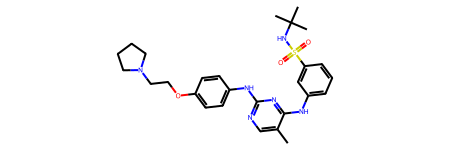

CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3


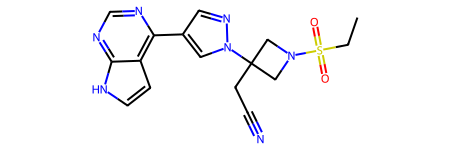

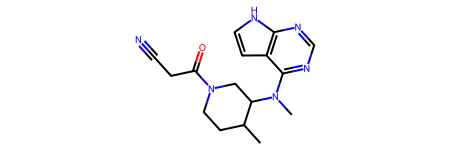

SELFIES
[C][C][=C][N][=C][Branch2][Ring1][S][N][=C][Ring1][=Branch1][N][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][S][=Branch1][C][=O][=Branch1][C][=O][N][C][Branch1][C][C][Branch1][C][C][C][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][C][C][N][C][C][C][C][Ring1][Branch1]


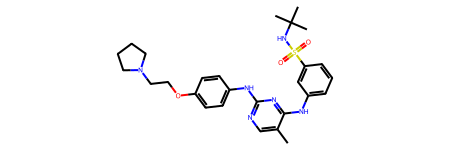

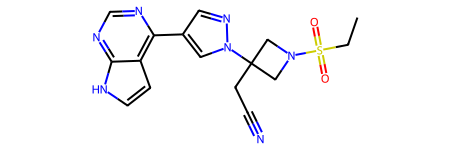

initial prediction, model no training


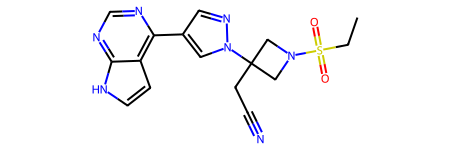

In [33]:
from IPython.display import display
from rdkit import Chem
m = Chem.MolFromSmiles

# converting smiles to selfies
fed = 'Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1'
bar = 'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3'
tof = 'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N'
src = sf.encoder(fed)
print('SMILES')
print(fed)
display(m(fed))
print(bar)
display(m(bar))
display(m(tof))
print('SELFIES')
print(src)
display(m(sf.decoder(src)))
src = sf.encoder(bar)
display(m(sf.decoder(src)))

print('initial prediction, model no training')
trg, att = translate(src, vocab, model, device, max_len=150)

display(m(sf.decoder("".join(trg))))

eval acc: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


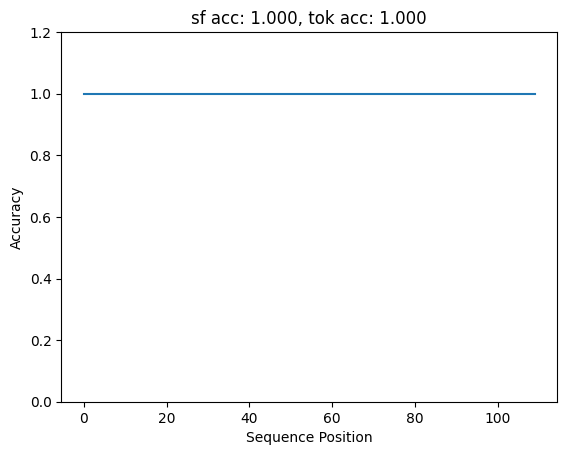

selfie accuracy: 1.000, token accuracy: 1.000


eval acc:   0%|          | 0/2 [00:00<?, ?it/s]

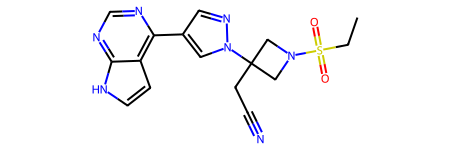

eval acc:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s]

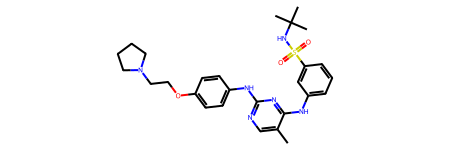

eval acc: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

selfie accuracy: 1.000, token accuracy: 1.000


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
def calc_reconstruction_accuracies(input_smiles, output_smiles,
                                   is_smiles=False, draw_fig=True,
                                   max_len=126):
    """Calculates SMILEs, token and positional accuracies for a set of\
    input and reconstructed SMILES strings
    input_smiles: list of string
    output_smiles: list of string
    is_smiles:
        True: input and output are both in SMILES form
        False: input and output are both in SELFIES form
    """
    smile_acc = 0
    hits = 0
    misses = 0
    position_accs = np.zeros((2, max_len))

    for in_smi, out_smi in zip(input_smiles, output_smiles):
        if is_smiles==False: # in_smi, out_smi are selfies
            # print(in_smi)
            in_smi = list(sf.split_selfies(in_smi))
            out_smi = list(sf.split_selfies(out_smi))

        if in_smi == out_smi:
            smile_acc += 1
            hits += len(in_smi)
            for j in range(len(in_smi)):
                position_accs[0, j] += 1
                position_accs[1, j] += 1

        else: #  in_smi is not the same as out smi
            misses += abs(len(in_smi) - len(out_smi))
            for j, (token_in, token_out) in enumerate(zip(in_smi, out_smi)):
                if token_in == token_out: hits += 1; position_accs[0, j] += 1
                else: misses += 1
                position_accs[1, j] += 1

    smile_acc /= len(input_smiles)
    token_acc = hits / (hits + misses)
    position_acc = []
    for i in range(max_len):
        if position_accs[1,i] != 0:
            position_acc.append(position_accs[0,i] / position_accs[1,i])
        else: break

    if draw_fig:
        plt.plot(position_acc)
        plt.xlabel('Sequence Position')
        plt.ylabel('Accuracy')
        plt.ylim(0,1.2)
        plt.title(f'sf acc: {smile_acc:.3f}, tok acc: {token_acc:.3f}')
        plt.show()
        plt.close()
    return smile_acc, token_acc, position_acc


def evaluate_acc(smile_list, draw_fig=True, display_mol=True):
    inp_selfies = []
    out_selfies = []
    for smi in tqdm(smile_list, total=len(smile_list), desc='eval acc'):
        selfi = sf.encoder(smi)
        inp_selfies.append(selfi)
        out, _ = translate(selfi, vocab, model, device, max_len=150)
        out_selfies.append("".join(out))
        if display_mol:
            try: display(m(sf.decoder("".join(out))))
            except: print('cannot display mol')

    sf_acc, tok_acc, pos_acc = calc_reconstruction_accuracies(
                                            inp_selfies, out_selfies,
                                            is_smiles=False, draw_fig=draw_fig)
    print(f'selfie accuracy: {sf_acc:.3f}, token accuracy: {tok_acc:.3f}')
rux = 'C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3'
# smile_list = [fed, bar, tof, rux]
# smile_list = [fed, bar]

with open(smile_dir, 'r') as f:
    smiles = [line.strip("\n") for line in f.readlines()]

smile_list = random.choices(smiles, k=10)
evaluate_acc(smile_list, draw_fig=True, display_mol=False)
evaluate_acc([bar, fed], draw_fig=False, display_mol=True)

Train Transformer, predict Fedratinib every epoch

eval acc:   0%|          | 0/2 [00:00<?, ?it/s]

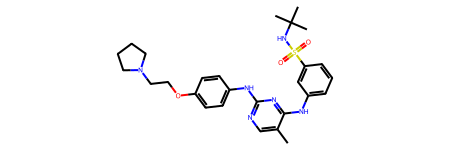

eval acc:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s]

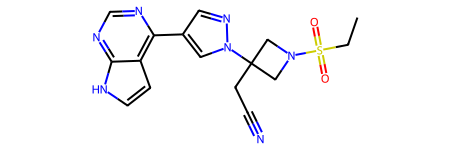

eval acc: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


selfie accuracy: 1.000, token accuracy: 1.000
prev loss: inf;  now  loss: 0.001, save model and evaluate


eval acc: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


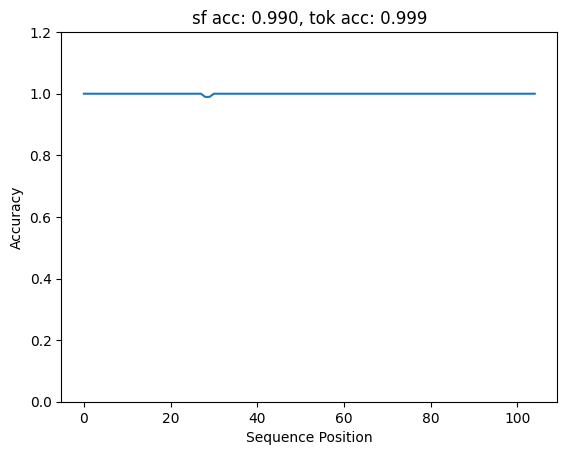

selfie accuracy: 0.990, token accuracy: 0.999
Epoch: 01 | Time: 2m 17s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.001 |  Val. PPL:   1.001


 74%|███████▍  | 389/525 [01:34<00:31,  4.28it/s]

In [ ]:
import time
import math
from IPython.display import display
from rdkit import Chem
m = Chem.MolFromSmiles

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS+100):
    start_time = time.time()
    train_loss = train(model, dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_dataloader, criterion)

    # trg, att = translate(src, vocab, model, device, max_len=150)
    # display(m(sf.decoder("".join(trg))))
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Display predicted structure of fedratinib and baricitinib
    evaluate_acc([fed, bar], draw_fig=False, display_mol=True)

    if valid_loss < best_valid_loss:
        print(f'prev loss: {best_valid_loss:.3f}; ',
              f'now  loss: {valid_loss:.3f}, save model and evaluate')
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

        # Random select k smiles, evaluate accuracy
        smile_list = random.choices(smiles, k=100)
        evaluate_acc(smile_list, draw_fig=True, display_mol=False)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [50]:
cd /content/

/content
